In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from birdclef.utils import get_spark
from pyspark.sql import Window, functions as F
import os

os.environ["SPARK_LOCAL_DIRS"] = "../data/tmp/spark"

spark = get_spark(cores=16, memory="5g")
df = spark.read.parquet("../data/processed/birdclef-2023/train_postprocessed/v4")
df = (
    df.withColumn("primary_label", F.col("metadata_species")[0])
    .withColumn("species", F.concat("metadata_species", "predicted_species"))
    .withColumn("species_count", F.count("*").over(Window.partitionBy("primary_label")))
)
df.printSchema()
df.show(n=5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/22 19:30:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- primary_label: string (nullable = true)
 |-- track_stem: string (nullable = true)
 |-- start_time: long (nullable = true)
 |-- metadata_species: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- predicted_species: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- next_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- track_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- species: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- species_count: long (nullable = false)



+-------------+----------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------+
|primary_label|track_stem|start_time|    metadata_species|predicted_species|           embedding|      next_embedding|     track_embedding|             species|species_count|
+-------------+----------+----------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------+
|      abythr1|  XC122413|         5|           [abythr1]|        [abythr1]|[1.6310796, 1.414...|[1.2752169, 0.833...|[1.3317069, 0.956...|  [abythr1, abythr1]|          249|
|      abythr1|  XC124898|        20|           [abythr1]|        [abythr1]|[1.1970673, 1.034...|[1.2697126, 1.132...|[1.1596123, 0.814...|  [abythr1, abythr1]|          249|
|      abythr1|  XC205444|        55|           [abythr1]|        [abythr1]|[1.0207641, 1.265...|[1.007165, 1.3399...|[1.3548

In [3]:
import pickle
import numpy as np
from xgboost import XGBClassifier
from pathlib import Path
import pandas as pd
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import average_precision_score


def model_eval(truth, preds):
    print("Accuracy:", accuracy_score(truth, preds))
    print(
        "Precision:",
        precision_score(truth, preds, average="macro"),
    )
    print(
        "Recall:",
        recall_score(truth, preds, average="macro"),
    )
    print(
        "F1 Score:",
        f1_score(truth, preds, average="macro"),
    )


def scorer(estimator, X, y):
    return average_precision_score(y, estimator.predict_proba(X), average="macro")

In [4]:
data = df.select(
    "predicted_species",
    "primary_label",
    "embedding",
    "next_embedding",
    "track_embedding",
    "species",
)
data.show(n=5)
data = data.toPandas()
data.head(n=5)

+------------------+-------------+--------------------+--------------------+--------------------+--------------------+
| predicted_species|primary_label|           embedding|      next_embedding|     track_embedding|             species|
+------------------+-------------+--------------------+--------------------+--------------------+--------------------+
|[ccbeat1, trobou1]|      ccbeat1|[1.523604, 0.9732...|[1.1461543, 0.864...|[1.3749335, 0.820...|[ccbeat1, ccbeat1...|
|         [ccbeat1]|      ccbeat1|[1.3187864, 0.715...|[1.048248, 0.5923...|[1.2631669, 0.720...|  [ccbeat1, ccbeat1]|
|         [ccbeat1]|      ccbeat1|[1.8044096, 1.101...|[1.598763, 1.4021...|[1.4022813, 1.254...|  [ccbeat1, ccbeat1]|
|         [blwlap1]|      blwlap1|[1.1090318, 1.610...|[0.97855157, 1.41...|[1.0207396, 1.540...|  [blwlap1, blwlap1]|
|         [blwlap1]|      blwlap1|[0.83208066, 2.13...|[0.4748551, 1.735...|[0.60793006, 1.83...|  [blwlap1, blwlap1]|
+------------------+-------------+--------------

,predicted_species,primary_label,embedding,next_embedding,track_embedding,species
0,"[ccbeat1, trobou1]",ccbeat1,"[1.523604, 0.9732575, 0.689221, 1.3162022, 0.7...","[1.1461543, 0.8640864, 0.45597965, 1.3028704, ...","[1.3749335, 0.8206999, 0.59814745, 1.2513487, ...","[ccbeat1, ccbeat1, trobou1]"
1,[ccbeat1],ccbeat1,"[1.3187864, 0.7150727, 0.9900959, 1.8962469, 0...","[1.048248, 0.59235334, 1.1732999, 1.5403138, 1...","[1.2631669, 0.7206624, 0.96723706, 1.7925037, ...","[ccbeat1, ccbeat1]"
2,[ccbeat1],ccbeat1,"[1.8044096, 1.1011962, 0.45975056, 1.6384436, ...","[1.598763, 1.4021178, 0.6835269, 1.7945755, 0....","[1.4022813, 1.25417, 0.71897155, 1.7009418, 0....","[ccbeat1, ccbeat1]"
3,[blwlap1],blwlap1,"[1.1090318, 1.6101218, 0.8621511, 0.33383822, ...","[0.97855157, 1.4101942, 0.6130494, 0.38137776,...","[1.0207396, 1.5406379, 0.66962916, 0.5683712, ...","[blwlap1, blwlap1]"
4,[blwlap1],blwlap1,"[0.83208066, 2.1329389, 0.6673165, 0.45887473,...","[0.4748551, 1.7359713, 0.677759, 0.7373171, 0....","[0.60793006, 1.8337458, 0.8447961, 0.520674, 0...","[blwlap1, blwlap1]"


Load Models

In [5]:
# best baseline, murillo call/nocall, global only, permutations
import pickle

baseline = pickle.loads(
    Path("../data/models/baseline/one-v-rest-xgbc-base.pkl").read_bytes()
)
baseline_mlb = pickle.loads(
    Path("../data/models/baseline/multilabel-binarizer.pkl").read_bytes()
)
call_nocall = pickle.loads(
    Path("../data/models/baseline/logistic_binary.pkl").read_bytes()
)
call_nocall_le = pickle.loads(
    Path("../data/models/baseline/logistic_binary_label_encoder.pkl").read_bytes()
)
permute = pickle.loads(
    Path("../data/models/baseline_v2/nzh-current-global-token.pkl").read_bytes()
)
permute_mlb = pickle.loads(
    Path("../data/models/baseline_v2/nzh-current-global-token_mlb.pkl").read_bytes()
)

Get Baseline Predictions

In [6]:
def explode_embedding(data, next=False, track=False):
    if next and track:
        return np.concatenate(
            (
                np.stack(data.embedding),
                np.stack(data.next_embedding),
                np.stack(data.track_embedding),
            ),
            axis=1,
        )
    elif next:
        return np.concatenate(
            (
                np.stack(data.embedding),
                np.stack(data.next_embedding),
            ),
            axis=1,
        )
    elif track:
        return np.concatenate(
            (
                np.stack(data.embedding),
                np.stack(data.track_embedding),
            ),
            axis=1,
        )
    else:
        return np.stack(data.embedding)


train, test = train_test_split(data, test_size=0.2, stratify=data.primary_label)

mlb = MultiLabelBinarizer()
mlb.fit(data.species)
train_y, test_y = mlb.transform(train.predicted_species), mlb.transform(
    test.predicted_species
)
print(len(mlb.classes_))

264


In [7]:
baseline_preds = baseline.predict_proba(explode_embedding(train, False, False))
baseline_test_preds = baseline.predict_proba(explode_embedding(test, False, False))

print(baseline_preds.shape, baseline_test_preds.shape)

(112483, 265) (28121, 265)


In [8]:
call_nocall_preds = call_nocall.predict_proba(explode_embedding(train, False, False))
call_nocall_test_preds = call_nocall.predict_proba(
    explode_embedding(test, False, False)
)

print(call_nocall_preds.shape, call_nocall_test_preds.shape)

(112483, 2) (28121, 2)


In [9]:
permute_preds = permute.predict_proba(explode_embedding(train, False, True))
permute_test_preds = permute.predict_proba(explode_embedding(test, False, True))

print(permute_preds.shape, permute_test_preds.shape)

(112483, 264) (28121, 264)


In [11]:
combined = np.concatenate((baseline_preds, call_nocall_preds, permute_preds), axis=1)
combined_test = np.concatenate(
    (baseline_test_preds, call_nocall_test_preds, permute_test_preds), axis=1
)

print(combined.shape, combined_test.shape)

(112483, 531) (28121, 531)


XGBoost Regressor

In [12]:
from xgboost import XGBRegressor

reg = XGBRegressor(tree_method="gpu_hist")
reg.fit(combined, train_y)
model_eval(test_y, reg.predict(combined_test))
print(
    "Average Precision Score",
    average_precision_score(test_y, reg.predict(combined_test)),
)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7f49ae51be50>>
Traceback (most recent call last):
  File "/home/nzhon/.local/lib/python3.10/site-packages/xgboost/core.py", line 500, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


In [ ]:
for i in range(len(preds)):
    for j in range(len(preds[i])):
        preds[i][j] = max(0, preds[i][j])
        preds[i][j] = min(1, preds[i][j])

In [ ]:
print(
    "Average Precision Score",
    average_precision_score(test_y, preds),
)

Average Precision Score 0.8958006477551285


In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(tree_method="gpu_hist")
clf.fit(combined, train_y)
model_eval(test_y, clf.predict(combined_test))
print(
    "Average Precision Score",
    average_precision_score(test_y, clf.predict_proba(combined_test)),
)

Accuracy: 0.8081860531275559
Precision: 0.9371847549602557
Recall: 0.8205466025321079
F1 Score: 0.8656491956009699
Average Precision Score 0.9444180445736489


In [ ]:
from pathlib import Path

pickle.dump(clf, Path("../data/models/baseline_v2/nzh-xgbc-ensemble.pkl").open("wb"))

Linear Models?

In [18]:
species = []

for predicted in data.predicted_species:
    uni = set(predicted)
    for s in uni:
        species.append(s)

dist = {}
for s in mlb.classes_:
    dist[s] = (species.count(s)) / len(species)
dist = [x for x in dist.values()]

In [36]:
no_call_index = list(baseline_mlb.classes_).index("no_call")
baseline_preds = np.delete(baseline_preds, no_call_index, axis=1)
baseline_test_preds = np.delete(baseline_test_preds, no_call_index, axis=1)
print(baseline_preds.shape, baseline_test_preds.shape)

(112483, 264) (28121, 264)


In [38]:
temp = call_nocall_preds[:, 0]
temp = temp[:, np.newaxis]
temp = temp * dist
print(temp.shape)

temp_test = call_nocall_test_preds[:, 0]
temp_test = temp_test[:, np.newaxis]
temp_test = temp_test * dist
print(temp_test.shape)

(112483, 264)
(28121, 264)


In [51]:
from sklearn.linear_model import LogisticRegression

first = np.concatenate(
    (
        baseline_preds[:, 0][:, np.newaxis],
        temp[:, 0][:, np.newaxis],
        permute_preds[:, 0][:, np.newaxis],
    ),
    axis=1,
)

first_truth = train_y[:, 0]

first_test = np.concatenate(
    (
        baseline_test_preds[:, 0][:, np.newaxis],
        temp_test[:, 0][:, np.newaxis],
        permute_test_preds[:, 0][:, np.newaxis],
    ),
    axis=1,
)

first_test_truth = test_y[:, 0]

print(first.shape, first_truth.shape)
print(first_test.shape, first_test_truth.shape)

logs = LogisticRegression()
logs.fit(first, first_truth)
model_eval(first_test_truth, logs.predict(first_test))
print(
    "average_precision_score",
    average_precision_score(first_test_truth, logs.predict_proba(first_test)[:, 1]),
)

(112483, 3) (112483,)
(28121, 3) (28121,)
Accuracy: 0.999964439386935
Precision: 0.9999822089382294
Recall: 0.9722222222222222
F1 Score: 0.9857053900251367
average_precision_score 1.0


In [61]:
linear_ens = {}

avp, coef1, coef2, coef3 = [], [], [], []

for i in range(264):
    species = mlb.classes_[i]

    temp_x = np.concatenate(
        (
            baseline_preds[:, i][:, np.newaxis],
            temp[:, i][:, np.newaxis],
            permute_preds[:, i][:, np.newaxis],
        ),
        axis=1,
    )
    temp_y = train_y[:, i]

    temp_test_x = np.concatenate(
        (
            baseline_test_preds[:, i][:, np.newaxis],
            temp_test[:, i][:, np.newaxis],
            permute_test_preds[:, i][:, np.newaxis],
        ),
        axis=1,
    )

    temp_test_y = test_y[:, i]

    logs = LogisticRegression()
    logs.fit(temp_x, temp_y)

    avp.append(
        average_precision_score(temp_test_y, logs.predict_proba(temp_test_x)[:, 1])
    )
    coef1.append(logs.coef_[0][0])
    coef2.append(logs.coef_[0][1])
    coef3.append(logs.coef_[0][2])

    linear_ens[species] = logs

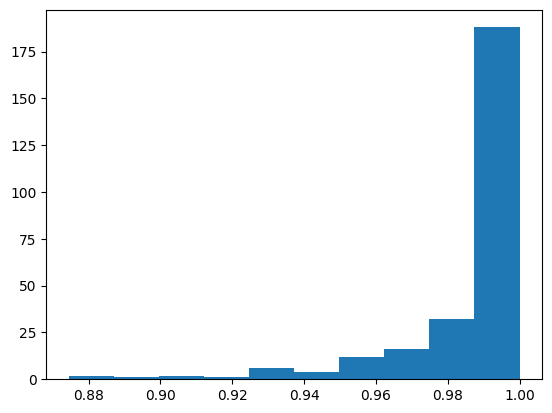

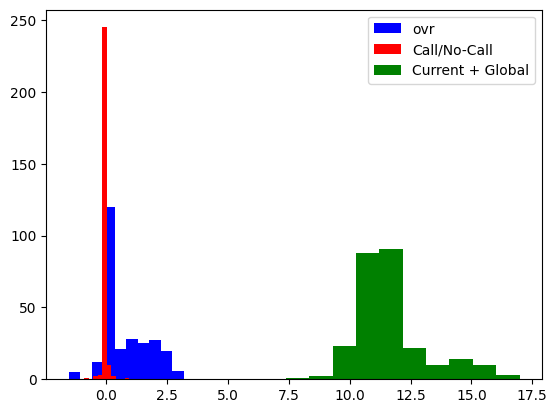

In [72]:
from matplotlib import pyplot as plt

plt.hist(avp)
plt.show()
plt.hist(coef1, color="blue")
plt.hist(coef2, color="red")
plt.hist(coef3, color="green")
plt.legend(["ovr", "Call/No-Call", "Current + Global"])
plt.show()

In [92]:
preds = None
probs = None
for i in range(264):
    temp_preds = linear_ens[mlb.classes_[i]].predict(
        np.concatenate(
            (
                baseline_test_preds[:, i][:, np.newaxis],
                temp_test[:, i][:, np.newaxis],
                permute_test_preds[:, i][:, np.newaxis],
            ),
            axis=1,
        )
    )
    temp_probs = linear_ens[mlb.classes_[i]].predict_proba(
        np.concatenate(
            (
                baseline_test_preds[:, i][:, np.newaxis],
                temp_test[:, i][:, np.newaxis],
                permute_test_preds[:, i][:, np.newaxis],
            ),
            axis=1,
        )
    )
    if preds is None:
        preds = temp_preds[:, np.newaxis]
    else:
        preds = np.concatenate((preds, temp_preds[:, np.newaxis]), axis=1)

    if probs is None:
        probs = temp_probs[:, 1][:, np.newaxis]
    else:
        probs = np.concatenate((probs, temp_probs[:, 1][:, np.newaxis]), axis=1)
print(preds.shape, probs.shape)
model_eval(test_y, preds)
average_precision_score(test_y, probs)

(28121, 264) (28121, 264)
Accuracy: 0.8614558514988798


/home/nzhon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9776707619439938
Recall: 0.9126197527730031
F1 Score: 0.9416598973777878


0.9882974249460511

Stacking Classifier

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class PrepareEmbedding(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        1 + 1

    def transform(self, X, next, track):
        if next and track:
            return np.concatenate(
                (
                    np.stack(X.embedding),
                    np.stack(X.next_embedding),
                    np.stack(X.track_embedding),
                ),
                axis=1,
            )
        elif next:
            return np.concatenate(
                (
                    np.stack(X.embedding),
                    np.stack(X.next_embedding),
                ),
                axis=1,
            )
        elif track:
            return np.concatenate(
                (
                    np.stack(X.embedding),
                    np.stack(X.track_embedding),
                ),
                axis=1,
            )
        else:
            return np.stack(X.embedding)

In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stk = StackingClassifier(
    estimators=[baseline, call_nocall, permute],
    final_estimator=LogisticRegression(),
    cv="prefit",
    stack_method="predict_proba",
    n_jobs=-1,
    verbose=1,
)
stk.fit(train_x, train_y)
model_eval(test_y, stk.predict(test_x))